# Augmenting time-series data
In this file, the data is augmented in order to create more of it.

In [2]:
# Imports
import sys
sys.path.insert(1,'../')
import Tools.data_processing as dp
import Tools.data_movement as dm 
import pandas as pd
from datetime import datetime
from datetime import timedelta
import copy
import random
import matplotlib.pyplot as plt
import math
from scipy.signal import find_peaks
import numpy as np
import scipy.ndimage as ndimage
import csv

## Helper Functions
The following functions provide useful tools for the augmentation process

In [23]:
def next_time_entry(current_entry: float) -> float:
    """
    This function returns the next time entry in julian time

    current_entry: a julina time float

    return: julian time + 15 minutes from past julian time
    """

    # convert julian to datetime
    date_time_init = dp.julian_to_datetime(current_entry)

    # find next date time (add 15 minutes)
    next_entry = date_time_init + timedelta(minutes=15)

    # convert date time to julian time
    final_julian_time = dp.datetime_to_julian(next_entry)

    # return julian time
    return final_julian_time


def reindex_augmented_data(data: pd.DataFrame, datatype: str) -> pd.DataFrame:
    """
    Reindex the augmented data so there are no overlaps

    data: the data to reindex
    datatype: fdom, turb, or stage

    returns: reindexed data
    """
    pass


def get_last_augment_index(dataframe) -> int:
    """
    Collects the last index of the augmented time series
    """
    return dataframe.shape[0]


# from auxuilary functions file
def get_candidates(data: np.ndarray, params: dict):

    """
    Return all peaks that should be scanned for out or order peaks(oop)
    We don't want to return skyrocketing peaks/local fluctuations - although they are oop,
    they will be caught by their respective algorithms

    data   : timeseries to scan for peaks
    return : peaks indentified with given hyperparameters and properties of those peaks
    """
    peaks, props = find_peaks(
        data[:, 1],
        height=(None, None),
        threshold=(None, None),
        distance=params["dist"],
        prominence=params["prom"],
        width=params["width"],
        wlen=params["wlen"],
        rel_height=params["rel_h"],
    )
    return peaks, props


def get_ends_of_peak(cands_df: pd.DataFrame, peak_index):
    """
    get left and right ends of a peak from the respective dataframes

    peak_dataset: fdom or turb

    peak_type: PP, SKP, PLP, etc.
    """
    # use cands_df to return left and right base of peak index
    new_cands = copy.deepcopy(cands_df)
    new_cands = new_cands.loc[new_cands["idx_of_peak"] == peak_index]

    left_base = new_cands["left_base"]
    right_base = new_cands["right_base"]

    left_base = left_base.to_list()
    left_base = left_base[0]

    right_base = right_base.to_list()
    right_base = right_base[0]

    # return left and right
    return left_base, right_base

def isInRange(indx, remove_ranges):
    for rng in remove_ranges:
        if rng[0] <= indx and indx <= rng[1]:
            return True
    return False

def low_pass_filter(data, window_len):
    """
    (2 * window_len) + 1 is the size of the window that determines the values that 
    influence the current measurement (middle of window)
    """
    kernel = np.lib.pad(np.linspace(1,3,window_len), (0,window_len -1), 'reflect')
    kernel = np.divide(kernel, np.sum(kernel))
    return ndimage.convolve(data, kernel)


def get_cands_fdom_pp():
    # pass fDOM data through low pass filter
    fDOM_data = dm.read_in_preprocessed_timeseries('../Data/converted_data/julian_format/fDOM_raw_10.1.2011-9.4.2020.csv')
    smoothed_signal = low_pass_filter(fDOM_data[:,1], 7)
    fDOM_data = np.column_stack((fDOM_data[:,0], smoothed_signal))

    candidate_params = {
        "prom": [3, None],
        "width": [None, None],
        "wlen": 200,
        "dist": 1,
        "rel_h": 0.6,
    }

    remove_ranges = [[17816, 17849], [108170, 108200], [111364, 111381]]

    peaks, props = get_candidates(fDOM_data, candidate_params)

    cands = [
        [
            peak,
            math.floor(props["left_ips"][i]),
            math.ceil(props["right_ips"][i]),
            props["prominences"][i],
        ]
        for i, peak in enumerate(peaks)
    ]

    # Remove erroneously detected peaks
    temp = []
    for peak in cands:
        if not (isInRange(peak[0], remove_ranges)):
            temp.append(peak)
    cands = copy.deepcopy(temp)

    df_cands_pp = pd.DataFrame(cands)

    # now load in ground truths, and drop all things in cands that are not anomaly peaks
   # Import ground truth values 
    truth_fname = '../Data/labeled_data/ground_truths/fDOM/fDOM_PP/julian_time/fDOM_PP_0k-300k.csv'

    truths = pd.read_csv(truth_fname)

    # drop all NPP indices
    truths = truths[truths["label_of_peak"] != "NPP"]

    # drop all rows in cnads that are not in truths
    df_cands_pp = df_cands_pp[df_cands_pp[0].isin(truths['idx_of_peak'])]

    # reindex frame
    df_cands_pp = df_cands_pp.rename(columns={0: "idx_of_peak", 1: "left_base", 2: "right_base", 3: "amplitude"}) 

    # return frame
    return df_cands_pp

def get_cands_fdom_skp():
    # load in fdom data
    fDOM_data = dm.read_in_preprocessed_timeseries('../Data/converted_data/julian_format/fDOM_raw_10.1.2011-9.4.2020.csv')

    # find peaks
    prominence_range = [5,None]
    width_range = [None,None]
    wlen = 100
    distance = 1
    rel_height =.6

    # Get list of all peaks that could possibly be plummeting peaks
    peaks, props = find_peaks(fDOM_data[:,1],
                              height = (None, None),
                              threshold = (None,None),
                              distance = distance,
                              prominence = prominence_range,
                              width = width_range,
                              wlen = wlen,
                              rel_height = rel_height)

    # Form candidate set from returned information
    cands = [[peak, math.floor(props['left_ips'][i]), math.ceil(props['right_ips'][i]),props['prominences'][i]] for i,peak in enumerate(peaks)]

    cands_df = pd.DataFrame(cands)

    # import truths
    truth_fname = '../Data/labeled_data/ground_truths/fDOM/fDOM_SKP/julian_time/fDOM_SKP_0k-300k.csv'

    truths = pd.read_csv(truth_fname)
    
    # drop all NSKP indices 
    truths = truths[truths["label_of_peak"] != "NSKP"]

    # drop all rows in cands that are not in truths
    cands_df = cands_df[cands_df[0].isin(truths["idx_of_peak"])]

    # rename cols
    cands_df = cands_df.rename(columns={0: "idx_of_peak", 1: "left_base", 2: "right_base", 3: "amplitude"})  

    return cands_df

def get_cands_fdom_plp():
    # load data
    fDOM_data = dm.read_in_preprocessed_timeseries('../Data/converted_data/julian_format/fDOM_raw_10.1.2011-9.4.2020.csv')

    # flip fdom
    flipped_fDOM = dp.flip_timeseries(copy.deepcopy(fDOM_data))

    # find peaks

    # Get fDOM plummeting peak candidate set using scipy find_peaks()
    prominence_range = [3,None] # peaks must have at least prominence 3
    width_range = [None,10] # peaks cannot have a base width of more than 5
    wlen = 100 
    distance = 1 
    rel_height =.6

    # Get list of all peaks that could possibly be plummeting peaks
    peaks, props = find_peaks(flipped_fDOM[:,1],
                              height = (None, None),
                              threshold = (None,None),
                              distance = distance,
                              prominence = prominence_range,
                              width = width_range,
                              wlen = wlen,
                              rel_height = rel_height)

    # Form candidate set from returned information
    cands = [[peak, math.floor(props['left_ips'][i]), math.ceil(props['right_ips'][i]),props['prominences'][i]] for i,peak in enumerate(peaks)]

    cands_df = pd.DataFrame(cands)

    # get truths
    truth_fname = '../Data/labeled_data/ground_truths/fDOM/fDOM_PLP/julian_time/fDOM_PLP_0k-300k.csv'
    truths = pd.read_csv(truth_fname)

    # drop all NPLP indices
    # TODO: if we want to allow non anomaly peaks, remove this line
    truths = truths[truths["label_of_peak"] != "NPLP"]

    # drop all rows in cands not in truths
    cands_df = cands_df[cands_df[0].isin(truths["idx_of_peak"])]

    # rename cols
    cands_df = cands_df.rename(columns={0: "idx_of_peak", 1: "left_base", 2: "right_base", 3: "amplitude"}) 

    # return data
    return cands_df

# TODO: implement this function
def get_cands_turb_pp():
    pass

In [32]:
# testing
cands = get_cands_fdom_plp()

print(cands)
peak_index = 195599

left, right = get_ends_of_peak(cands, peak_index)

print("peak index: " + str(peak_index) + " left peak base: " + str(left) + " right peak base: " + str(right))

     idx_of_peak  left_base  right_base  amplitude
144        17835      17834       17836  33.777750
171        32981      32980       32982  12.983361
176        33668      33666       33669  12.719339
215        50450      50449       50451  13.351717
217        50651      50650       50652   4.047270
219        52170      52169       52171   4.150748
228        67957      67956       67958   8.430801
230        68081      68080       68083  19.252486
234        69376      69375       69377  14.896352
256       103335     103334      103336   6.479803
271       115354     115351      115355  12.527648
272       115364     115363      115365  12.002875
276       116209     116208      116210   7.737090
290       124708     124707      124709  19.732674
323       158219     158218      158220   4.536070
324       158225     158224      158226  10.916358
338       178023     178020      178024  17.477806
346       180757     180756      180758  26.016321
347       180763     180762    

/var/folders/3w/lhkpgfc505n81_2vs8svxfpr0000gn/T/ipykernel_7050/3935076189.py:220: PeakPropertyWarning: some peaks have a prominence of 0
  peaks, props = find_peaks(flipped_fDOM[:,1],


## Loading in data
The knowledge-based approach uses the data in `Data/converted_data/julian_format/`, so that is where the data augmentation will go.

In [4]:
# Read in raw data
fDOM_data = dm.read_in_preprocessed_timeseries(
    "../Data/converted_data/julian_format/fDOM_raw_10.1.2011-9.4.2020.csv"
)
stage_data = dm.read_in_preprocessed_timeseries(
    "../Data/converted_data/julian_format/stage_10.1.11-1.1.19.csv"
)
turb_data = dm.read_in_preprocessed_timeseries(
    "../Data/converted_data/julian_format/turbidity_raw_10.1.2011_9.4.2020.csv"
)

# align stage to fDOM
stage_data = dp.align_stage_to_fDOM(fDOM_data, stage_data)

# read in labeled fDOM
fDOM_labeled = pd.read_csv(
    "../Data/labeled_data/ground_truths/fDOM/fDOM_all_julian_0k-300k.csv"
)

# read in labeled turb
turb_labeled = pd.read_csv(
    "../Data/labeled_data/ground_truths/turb/turb_pp/julian_time/turb_pp_0k-300k_labeled.csv"
)

# New data folder:
AUGMENT_DATA_PATH = "../Data/augmented_data/julian_format/"


In [5]:
# Convert data into pandas dataframes for better indexing:
fDOM_raw = pd.DataFrame(fDOM_data)
fDOM_raw.columns = ["timestamp", "value"]

turb_raw = pd.DataFrame(turb_data)
turb_raw.columns = ["timestamp", "value"]

stage_raw = pd.DataFrame(stage_data)
stage_raw.columns = ["timestamp", "value"]

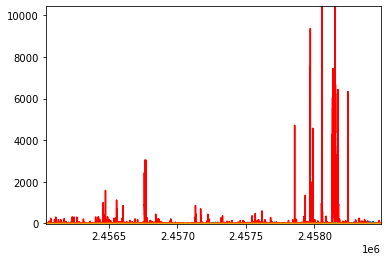

In [6]:
"""
Visualize data
"""
fig = plt.figure()
x = fDOM_raw['timestamp']
y = turb_raw['value']

line_fdom = plt.Line2D(fDOM_raw['timestamp'], fDOM_raw['value'])
line_turb = plt.Line2D(turb_raw['timestamp'], turb_raw['value'], color='red')
line_stage = plt.Line2D(stage_raw['timestamp'], stage_raw['value'], color='orange')
ax = fig.add_subplot(111)

ax.add_line(line_fdom)
ax.add_line(line_turb)
ax.add_line(line_stage)
ax.set_xlim(min(x), max(x))
ax.set_ylim(min(y) - 10, max(y) + 10)

plt.show()

## Augmenting Data
We will augment data for each type of peak, and for each measurement.

Starting with fDOM:
1. PLP (plummeting peak)
2. PP (phantom peak)
3. SKP (skyrocketing peak)

TODO: augment more peak types when they are labeled

With turbidity:
1. PP

### Constants
We define two constants for use with augmenting the data:
1. `TIME_RANGE_INIT`: the number of points before and after the relative peak that we take data from
2. `ITERATIONS`: the number of times we loop over the list of anomaly peaks, and augment them
3. `STARTING_TIMESTAMP`: the timestamp to start all augmented data at. The default value is 15 minutes after the last data measurement from the original set up data given to the project devs. As of 2/16/22, this timestamp is correct.

In [7]:
""" Helpful constants """
TIME_RANGE_INIT = 30  # the base time range for peaks, in number of data points(MUST BE 1 OR HIGHER), this is used as a fallback
ITERATIONS = 5 # number of times to loop over dataset and augment
STARTING_TIMESTAMP = 2459096.9583333335
LOWER_BOUND_AMPLITUDE_MULTIPLIER = -0.1
UPPER_BOUND_AMPLITUDE_MULTIPLIER = 0.1

### Augmenting fDOM

In [36]:
#####################################################################################
#                                                                                   #
#                               DATAFRAME SETUP SECTION                             #
#                                                                                   #
#####################################################################################

# new dataframes for augmented labeled/raw fDOM
augmented_fDOM_raw = pd.DataFrame(columns=["timestamp", "value"])
augmented_fDOM_labeled = pd.DataFrame(
    columns=["timestamp_of_peak", "value_of_peak", "label_of_peak", "idx_of_peak"]
)

# dataframe for augmented stage
augmented_stage_raw_fdom = pd.DataFrame(columns=["timestamp", "value"])

# dataframes for augmented raw/labeled turbidity
augmented_turb_raw_fdom = pd.DataFrame(columns=["timestamp", "value"])
augmented_turb_labeled_fdom = pd.DataFrame(
    columns=["timestamp_of_peak", "value_of_peak", "label_of_peak", "idx_of_peak"]
)

# use scipy find peaks to get detected peaks
# need to iterate over every labeled peak, and get the beginning and end from a specific list somehow

# variable to keep the last entry in the dataframe for stage
# defaults to the last entry that was in fdom/turb raw csv files, in julian format
prev_added_entry = STARTING_TIMESTAMP

# a list of peaks that don't align with the fDOM raw file that was aligned with stage
# i believe its just peaks that don't align with stage in general for whatever reason
missed_fDOM_peaks = []

# ~~~~~ Collect starting and ending points of each fDOM peak type ~~~~~
# PP

# load in candidates from detect_fDOM_PP
fdom_pp_index_lookup = get_cands_fdom_pp()

## SKP
fdom_skp_index_lookup = get_cands_fdom_skp()

## PLP
fdom_plp_index_lookup = get_cands_fdom_plp()

#####################################################################################
#                                                                                   #
#                               AUGMENT DATA SECTION                                #
#                                                                                   #
#####################################################################################

for iteration in range(ITERATIONS):
    """
    Re-sample the fDOM labeled peaks to add variance to data
    """
    # labeled fDOM peaks
    fdom_anon_peaks = fDOM_labeled[fDOM_labeled["label_of_peak"] != "NAP"]
    # randomize the order, to add more
    fdom_anon_peaks = fdom_anon_peaks.sample(frac=1).reset_index(
        drop=True
    )  # reset index as values were removed

    # iterate over each peak
    for i, row in fdom_anon_peaks.iterrows():
        # check to see if any overlap occurs between peaks

        # Get raw fDOM data points
        timestamp_of_peak = fdom_anon_peaks.loc[i, "timestamp_of_peak"]
        label_of_peak = fdom_anon_peaks.loc[i, "label_of_peak"]

        # get index dataframes of each type
        fdom_index_df = fDOM_raw[fDOM_raw["timestamp"] == timestamp_of_peak]
        stage_index_df = stage_raw[stage_raw["timestamp"] == timestamp_of_peak]
        turb_index_df = turb_raw[turb_raw["timestamp"] == timestamp_of_peak]

        if len(fdom_index_df.index.to_list()) != 0:
            # get indices of each data type from index df's
            index_of_peak = fdom_index_df.index.tolist()[0]
            stage_index = stage_index_df.index.tolist()[0]
            turb_index = turb_index_df.index.tolist()[0]

            prev_dist = TIME_RANGE_INIT
            next_dist = TIME_RANGE_INIT

            # set cands_df based on our peak label
            if label_of_peak == "PP":
                cands_df = fdom_pp_index_lookup
            elif label_of_peak == "PLP":
                cands_df = fdom_plp_index_lookup
            elif label_of_peak == "SKP":
                cands_df = fdom_skp_index_lookup

            # call get ends of peak to get beginning and ending of peaks
            try:
                left, right = get_ends_of_peak(cands_df, index_of_peak)

                prev_dist = abs(index_of_peak - left)
                next_dist = abs(index_of_peak - right)

            except IndexError:
                # something went wrong, just set prev_dist and next dist to time range init
                prev_dist = TIME_RANGE_INIT
                next_dist = TIME_RANGE_INIT

            finally:

                # use this timestamp to make a dataframe of raw stuff
                # get data from fDOM_raw file
                fDOM_raw_time_range = pd.DataFrame(
                    fDOM_raw.iloc[index_of_peak - prev_dist : index_of_peak + next_dist + 1]
                )

                # get stage data range
                stage_time_range = pd.DataFrame(
                    stage_raw.iloc[stage_index - prev_dist : stage_index + next_dist + 1]
                )

                # get turbidity data range
                turb_time_range = pd.DataFrame(
                    turb_raw.iloc[turb_index - prev_dist : turb_index + next_dist + 1]
                )

                # make a copy of the modified data
                new_fdom_raw = copy.deepcopy(fDOM_raw_time_range)
                new_stage = copy.deepcopy(stage_time_range)
                new_turb_raw = copy.deepcopy(turb_time_range)

                # peak index can change when we add in x data
                new_fdom_peak_index = -1
                new_peak_timestamp = -1

                #####################################################################################
                #                                                                                   #
                #                               ACTUAL CHANGES TO DATA                              #
                #                                                                                   #
                #####################################################################################

                # gen a random number 0 or 1, if 0, widen, if 1, increase peak val
                # set seed
                random.seed()
                widen_or_heighten = random.randint(0, 1)

                # if 0, we widen
                if widen_or_heighten == 0:
                    # TODO: ensure this worked...

                    # get current peak val
                    main_peak_val = new_fdom_raw.loc[index_of_peak, "value"]

                    # gen a random number between 0.01 and 0.2 to increase height by for previous and next peak
                    multiplier = random.uniform(0.001, 0.2)

                    # new peak vals
                    val_before_peak = new_fdom_raw.loc[index_of_peak - 1, "value"] * (
                        1 + multiplier
                    )
                    val_after_peak = new_fdom_raw.loc[index_of_peak + 1, "value"] * (
                        1 + multiplier
                    )

                    # ensure new value does not go over main peak val
                    fail_count = 0
                    can_widen = True
                    while (
                        val_before_peak > main_peak_val and val_after_peak > main_peak_val
                    ):
                        fail_count += 1
                        if fail_count > 20:
                            # not possible to fix peak, break and forget about it
                            can_widen = False
                            break

                        # re gen num
                        multiplier = random.uniform(0.001, 0.2)
                        val_before_peak = new_fdom_raw.loc[index_of_peak - 1, "value"] * (
                            1 + multiplier
                        )
                        val_after_peak = new_fdom_raw.loc[index_of_peak + 1, "value"] * (
                            1 + multiplier
                        )

                    if can_widen:
                        # set new vals
                        new_fdom_raw.loc[index_of_peak - 1, "value"] = val_before_peak
                        new_fdom_raw.loc[index_of_peak + 1, "value"] = val_after_peak

                    # if we cant widen, lets just increase main peak amp
                    else:
                        random_val = random.uniform(
                            LOWER_BOUND_AMPLITUDE_MULTIPLIER,
                            UPPER_BOUND_AMPLITUDE_MULTIPLIER,
                        )
                        new_peak_val = new_fdom_raw.loc[index_of_peak, "value"] * (
                            1 + random_val
                        )
                        new_fdom_raw.loc[index_of_peak, "value"] = new_peak_val

                # else we heighten
                else:
                    # gen a random number to multiply amplitude by
                    random_val = random.uniform(
                        LOWER_BOUND_AMPLITUDE_MULTIPLIER, UPPER_BOUND_AMPLITUDE_MULTIPLIER
                    )
                    new_peak_val = new_fdom_raw.loc[index_of_peak, "value"] * (
                        1 + random_val
                    )
                    new_fdom_raw.loc[index_of_peak, "value"] = new_peak_val

                # get the next possible timestamp
                new_time_entry = next_time_entry(prev_added_entry)

                # update all timestamps for augmented data
                for i, row in new_fdom_raw.iterrows():
                    # if timestamps equal, we have the relative peak
                    if new_fdom_raw.loc[i, "timestamp"] == timestamp_of_peak:
                        # register index here
                        new_fdom_peak_index = get_last_augment_index(augmented_fDOM_raw)
                        new_peak_timestamp = new_time_entry

                    # update timestamps
                    new_fdom_raw.loc[i, "timestamp"] = new_time_entry
                    new_stage.loc[i, "timestamp"] = new_time_entry
                    new_turb_raw.loc[i, "timestamp"] = new_time_entry

                    # get next time stamp
                    new_time_entry = next_time_entry(new_time_entry)

                # add entries into raw fDOM
                augmented_fDOM_raw = pd.concat(
                    [augmented_fDOM_raw, new_fdom_raw], ignore_index=True
                )

                new_label = pd.DataFrame(
                    [
                        [
                            new_peak_timestamp,
                            new_peak_val,
                            label_of_peak,
                            new_fdom_peak_index,
                        ]
                    ],
                    columns=[
                        "timestamp_of_peak",
                        "value_of_peak",
                        "label_of_peak",
                        "idx_of_peak",
                    ],
                )

                # add entries to labeled fDOM
                augmented_fDOM_labeled = pd.concat([augmented_fDOM_labeled, new_label])

                # add entries to stage
                augmented_stage_raw_fdom = pd.concat(
                    [augmented_stage_raw_fdom, new_stage], ignore_index=True
                )

                # add entries to turb
                augmented_turb_raw_fdom = pd.concat(
                    [augmented_turb_raw_fdom, new_turb_raw], ignore_index=True
                )

                # update prev time entry
                prev_added_entry = new_time_entry

        else:
            # we missed some data points, append them to the missed data dataframe
            missed_fDOM_peaks.append(timestamp_of_peak)


/var/folders/3w/lhkpgfc505n81_2vs8svxfpr0000gn/T/ipykernel_7050/3935076189.py:220: PeakPropertyWarning: some peaks have a prominence of 0
  peaks, props = find_peaks(flipped_fDOM[:,1],


In [34]:
"""
This cell allows you to print out the augmented dataframes in full
"""

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

print("Labeled Peaks Augmented")
print(augmented_fDOM_labeled)
print("\n")

print("Raw fDOM Augmented")
print(augmented_fDOM_raw)
print("\n")

print("Raw Stage Augmented")
print(augmented_stage_raw_fdom)
print("\n")

# print("Raw Turbidity Augmented")
# print(augmented_turb_raw_fdom)

Labeled Peaks Augmented
  timestamp_of_peak value_of_peak label_of_peak idx_of_peak
0     2459097.104         32.3           PP            0   
0     2459097.458         32.3           PP           23   
0     2459097.812        33.46           PP           63   
0     2459098.115       41.868           PP           88   
0     2459098.479       41.868           PP          129   
0     2459098.667       41.868          SKP          157   
0     2459098.708        5.458          PLP          160   
0     2459098.969       36.144           PP          163   
0     2459099.198       -0.042          PLP          205   
0     2459099.594       32.007           PP          210   
0     2459099.958       32.007           PP          261   
0     2459100.208       37.148           PP          289   
0     2459100.552       37.148           PP          321   
0     2459100.958       37.148           PP          363   
0     2459101.062       37.148          SKP          378   
0     2459101.10

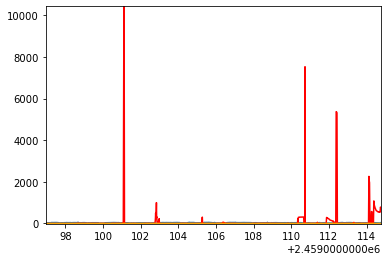

In [35]:
"""
Visualize data with matplotlib
"""
fig = plt.figure()
x = augmented_turb_raw_fdom['timestamp']
y = augmented_turb_raw_fdom['value']

line_fdom = plt.Line2D(augmented_fDOM_raw['timestamp'], augmented_fDOM_raw['value'])
line_turb = plt.Line2D(augmented_turb_raw_fdom['timestamp'], augmented_turb_raw_fdom['value'], color='red')
line_stage = plt.Line2D(augmented_stage_raw_fdom['timestamp'], augmented_stage_raw_fdom['value'], color='orange')
ax = fig.add_subplot(111)

ax.add_line(line_fdom)
ax.add_line(line_turb)
ax.add_line(line_stage)
ax.set_xlim(min(x), max(x))
ax.set_ylim(min(y) - 10, max(y) + 10)

plt.show()

### Augment turbidity data
The following code blocks augment turbidity data.

In [ ]:
#####################################################################################
#                                                                                   #
#                               DATAFRAME SETUP SECTION                             #
#                                                                                   #
#####################################################################################

# labeled turb
augmented_turb_labeled = pd.DataFrame(
    columns=["timestamp_of_peak", "value_of_peak", "label_of_peak", "idx_of_peak"]
)

# raw turb
augmented_turb_raw = pd.DataFrame(columns=["timestamp", "value"])

# raw fdom
augmented_fDOM_raw_turb = pd.DataFrame(columns=["timestamp", "value"])

# raw stage
augmented_stage_raw_turb = pd.DataFrame(columns=["timestamp", "value"])

# variable to keep the last entry in the dataframe for stage
# defaults to the last entry that was in fdom/turb raw csv files, in julian format
prev_added_entry = STARTING_TIMESTAMP

# a list of peaks that don't align with the fDOM raw file that was aligned with stage
# i believe its just peaks that don't align with stage in general for whatever reason
missed_turb_peaks = []

#####################################################################################
#                                                                                   #
#                               AUGMENT DATA SECTION                                #
#                                                                                   #
#####################################################################################

""" Augment turbidity data by calling previously written function """
for iteration in range(ITERATIONS):
    """ Resample turb labeled peaks at each iteration for more variance """
    # labeled turb peaks
    turb_anon_peaks = turb_labeled[turb_labeled["label_of_peak"] != "NPP"]
    turb_anon_peaks = turb_anon_peaks.sample(frac=1).reset_index()

    # iterate over each peak
    for i, row in turb_anon_peaks.iterrows():
        # check to see if any overlap occurs between peaks
        prev_dist = TIME_RANGE_INIT
        next_dist = TIME_RANGE_INIT

        """Get raw turb data points"""
        timestamp_of_peak = turb_anon_peaks.loc[i, "timestamp_of_peak"]
        label_of_peak = turb_anon_peaks.loc[i, "label_of_peak"]

        # get index dataframes of each type
        fdom_index_df = fDOM_raw[fDOM_raw["timestamp"] == timestamp_of_peak]
        stage_index_df = stage_raw[stage_raw["timestamp"] == timestamp_of_peak]
        turb_index_df = turb_raw[turb_raw["timestamp"] == timestamp_of_peak]

        if len(turb_index_df.index.to_list()) != 0:
            # get indices of each data type from index df's
            index_of_peak = turb_index_df.index.tolist()[0]
            stage_index = stage_index_df.index.tolist()[0]
            fdom_index = fdom_index_df.index.tolist()[0]

            # use this timestamp to make a dataframe of raw stuff
            # get data from fDOM_raw file
            fDOM_raw_time_range = pd.DataFrame(
                fDOM_raw.iloc[fdom_index - prev_dist : fdom_index + next_dist]
            )

            # get stage data range
            stage_time_range = pd.DataFrame(
                stage_raw.iloc[stage_index - prev_dist : stage_index + next_dist]
            )

            # get turbidity data range
            turb_time_range = pd.DataFrame(
                turb_raw.iloc[index_of_peak - prev_dist : index_of_peak + next_dist]
            )

            # make a copy of the modified data
            new_fdom_raw = copy.deepcopy(fDOM_raw_time_range)
            new_stage = copy.deepcopy(stage_time_range)
            new_turb_raw = copy.deepcopy(turb_time_range)

            # peak index can change when we add in x data
            new_fdom_peak_index = -1
            new_peak_timestamp = -1
            
            #####################################################################################
            #                                                                                   #
            #                               ACTUAL CHANGES TO DATA                              #
            #                                                                                   #
            #####################################################################################

            # gen random num to decide whether to widen or heighten
            random.seed() 
            widen_or_heighten = random.randint(0, 1)

            # if 0, widen the peak
            if widen_or_heighten == 0:
               # get current peak val
                main_peak_val = new_turb_raw.loc[index_of_peak, "value"]

                # gen a random number between 0.01 and 0.2 to increase height by for previous and next peak
                multiplier = random.uniform(0.001, 0.2)
                
                # new peak vals
                val_before_peak = new_turb_raw.loc[index_of_peak - 1, "value"] * (1 + multiplier)
                val_after_peak = new_turb_raw.loc[index_of_peak + 1, "value"] * (1 + multiplier)

                # ensure new value does not go over main peak val
                fail_count = 0
                can_widen = True
                while val_before_peak > main_peak_val and val_after_peak > main_peak_val:
                    fail_count += 1 
                    if fail_count > 20:
                        # not possible to fix peak, break and forget about it
                        can_widen = False
                        break 
                    
                    # re gen num
                    multiplier = random.uniform(0.001, 0.2)
                    val_before_peak = new_turb_raw.loc[index_of_peak - 1, "value"] * (1 + multiplier)
                    val_after_peak = new_turb_raw.loc[index_of_peak + 1, "value"] * (1 + multiplier) 
                
                if can_widen:
                    # set new vals
                    new_turb_raw.loc[index_of_peak - 1, "value"] = val_before_peak
                    new_turb_raw.loc[index_of_peak + 1, "value"] = val_after_peak 
            
            # else, lets heighten the peak
            else:
                random_val = random.uniform(LOWER_BOUND_AMPLITUDE_MULTIPLIER, UPPER_BOUND_AMPLITUDE_MULTIPLIER)
                new_peak_val = new_turb_raw.loc[index_of_peak, "value"] * (1 + random_val)
                new_turb_raw.loc[index_of_peak, "value"] = new_peak_val

            # get the next possible timestamp
            new_time_entry = next_time_entry(prev_added_entry)

            # update all timestamps for augmented data
            for i, row in new_turb_raw.iterrows():
                # if timestamps equal, we have the relative peak
                if new_turb_raw.loc[i, "timestamp"] == timestamp_of_peak:
                    # register index here
                    new_turb_peak_index = get_last_augment_index(augmented_turb_raw)
                    new_peak_timestamp = new_time_entry

                # update timestamps
                new_fdom_raw.loc[i, "timestamp"] = new_time_entry
                new_stage.loc[i, "timestamp"] = new_time_entry
                new_turb_raw.loc[i, "timestamp"] = new_time_entry

                # get next time stamp
                new_time_entry = next_time_entry(new_time_entry)

            # add entries to turb
            augmented_turb_raw = pd.concat(
                [augmented_turb_raw, new_turb_raw], ignore_index=True
            )

            new_label = pd.DataFrame(
                [
                    [
                        new_peak_timestamp,
                        new_peak_val,
                        label_of_peak,
                        new_turb_peak_index,
                    ]
                ],
                columns=[
                    "timestamp_of_peak",
                    "value_of_peak",
                    "label_of_peak",
                    "idx_of_peak",
                ],
            )

            # add entries to labeled turb
            augmented_turb_labeled = pd.concat([augmented_turb_labeled, new_label])

            # add entries to stage
            augmented_stage_raw_turb = pd.concat(
                [augmented_stage_raw_turb, new_stage], ignore_index=True
            )

            # add entries into raw fDOM
            augmented_fDOM_raw_turb = pd.concat(
                [augmented_fDOM_raw_turb, new_fdom_raw], ignore_index=True
            )

            # update prev time entry
            prev_added_entry = new_time_entry

        else:
            # we missed some data points, append them to the missed data dataframe
            missed_fDOM_peaks.append(timestamp_of_peak)


In [ ]:
"""
This cell allows you to print out the augmented dataframes in full
"""

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', 1000)
# pd.set_option('display.colheader_justify', 'center')
# pd.set_option('display.precision', 3)

# print("Labeled Peaks Augmented")
# print(augmented_turb_labeled)
# print("\n")

# print("Raw fDOM Augmented")
# print(augmented_fDOM_raw_turb)
# print("\n")

# print("Raw Stage Augmented")
# print(augmented_stage_raw_turb)
# print("\n")

# print("Raw Turbidity Augmented")
# print(augmented_turb_raw)

In [ ]:
"""
Visualize data with matplotlib
"""
fig = plt.figure()
x = augmented_turb_raw['timestamp']
y = augmented_turb_raw['value']

line_fdom = plt.Line2D(augmented_fDOM_raw_turb['timestamp'], augmented_fDOM_raw_turb['value'])
line_turb = plt.Line2D(augmented_turb_raw['timestamp'], augmented_turb_raw['value'], color='red')
line_stage = plt.Line2D(augmented_stage_raw_turb['timestamp'], augmented_stage_raw_turb['value'], color='orange')
ax = fig.add_subplot(111)

ax.add_line(line_fdom)
ax.add_line(line_turb)
ax.add_line(line_stage)
ax.set_xlim(min(x), max(x))
ax.set_ylim(min(y) - 10, max(y) + 10)

plt.show()

## Move augmented data into csv files
The following codeblock creates csv files for the augmented data.

### NOTE ON DATA:
Due to the random sampling used when augmenting fDOM and turbidity,

In [ ]:
""" Augmented Data Paths """
# trainset
trainset_fdom_path = "../Data/augmented_data/trainset_plotting/fdom/"
trainset_turb_path = "../Data/augmented_data/trainset_plotting/turb/"

# unlabeled data
unlabeled_fdom_path = "../Data/augmented_data/fdom/unlabeled/"
unlabeled_turb_path = "../Data/augmented_data/turb/unlabeled/"

# labeled data
labeled_fdom_path = "../Data/augmented_data/fdom/labeled/"
labeled_turb_path = "../Data/augmented_data/turb/labeled/"

In [ ]:
def write_augmented_data_to_csv():
    # call to_csv for each dataframe
    # for each dataframe, we also drop the index

    # write fDOM augmented data
    augmented_fDOM_labeled.to_csv(labeled_fdom_path + 'labeled_fdom_peaks.csv', index=False)
    augmented_fDOM_raw.to_csv(unlabeled_fdom_path + 'unlabeled_fdom.csv', index=False)
    augmented_turb_raw_fdom.to_csv(unlabeled_fdom_path + 'unlabeled_turb.csv', index=False)
    augmented_stage_raw_fdom.to_csv(unlabeled_fdom_path + 'unlabeled_stage.csv', index=False)

    # write turb augmented data
    augmented_turb_labeled.to_csv(labeled_turb_path + 'labeled_turb_peaks.csv', index=False)
    augmented_turb_raw.to_csv(unlabeled_turb_path + 'unlabeled_turb.csv', index=False)
    augmented_fDOM_raw_turb.to_csv(unlabeled_turb_path + 'unlabeled_fdom.csv', index=False)
    augmented_stage_raw_turb.to_csv(unlabeled_turb_path + 'unlabeled_stage.csv', index=False)


def convert_df_julian_to_datetime(df: pd.DataFrame) -> pd.DataFrame:
    """
    Converts a dataframe julian timestamp to datetime ISO 8601 format

    df: a dataframe

    return: changed dataframe
    """
    # iterate over dataframe, replacing timestamp vals
    for i, row in df.iterrows():
        df.loc[i, "timestamp"] = dp.julian_to_datetime(df.loc[i, "timestamp"]).isoformat()
        
        # add stupid 0.00Z to fit trainset format
        df.loc[i, "timestamp"] = df.loc[i, "timestamp"] + ".000Z"

    return df

def write_to_trainset_csv():
    # TODO: add peak labels in

    # start by creating a dataframe that has the correct columns
    trainset_fdom_df = pd.DataFrame(columns=["series", "timestamp", "value", "label"])
    trainset_turb_df = pd.DataFrame(columns=["series", "timestamp", "value", "label"])

    # ~~~~~~~ fDOM section ~~~~~~~
    # start by just adding the fDOM data into the series, need to replace all timestamps
    fdom_trainset_raw = copy.deepcopy(augmented_fDOM_raw)
    fdom_turb_trainset_raw = copy.deepcopy(augmented_turb_raw_fdom)
    fdom_stage_trainset_raw = copy.deepcopy(augmented_stage_raw_fdom)
    
    # convert timestamps to julian
    fdom_trainset_raw = convert_df_julian_to_datetime(fdom_trainset_raw)
    fdom_turb_trainset_raw = convert_df_julian_to_datetime(fdom_turb_trainset_raw)
    fdom_stage_trainset_raw = convert_df_julian_to_datetime(fdom_stage_trainset_raw)

    # add in new values
    fdom_trainset_raw["series"] = "fDOM"
    fdom_trainset_raw["label"] = ""

    fdom_turb_trainset_raw["series"] = "turb"
    fdom_turb_trainset_raw["label"] = ""

    fdom_stage_trainset_raw["series"] = "stage"
    fdom_stage_trainset_raw["label"] = ""

    # reorder columns
    fdom_trainset_raw = fdom_trainset_raw.reindex(columns=["series", "timestamp", "value", "label"])
    fdom_turb_trainset_raw = fdom_turb_trainset_raw.reindex(columns=["series", "timestamp", "value", "label"])
    fdom_stage_trainset_raw = fdom_stage_trainset_raw.reindex(columns=["series", "timestamp", "value", "label"])

    # concat into single dataframe
    trainset_fdom_df = pd.concat([fdom_trainset_raw, fdom_turb_trainset_raw, fdom_stage_trainset_raw])

    # sort together
    trainset_fdom_df = trainset_fdom_df.sort_values(by=['timestamp'], kind='stable')

    # export to csv
    trainset_fdom_df.to_csv(trainset_fdom_path + "fdom_augmented.csv", index=False)

    # ~~~~~~~ turbidity section ~~~~~~~

    # create new dataframes
    turb_trainset_raw = copy.deepcopy(augmented_turb_raw)
    turb_fdom_trainset_raw = copy.deepcopy(augmented_fDOM_raw_turb)
    turb_stage_trainset_raw = copy.deepcopy(augmented_stage_raw_turb)

    # convert timestamps
    turb_trainset_raw = convert_df_julian_to_datetime(turb_trainset_raw)
    turb_fdom_trainset_raw = convert_df_julian_to_datetime(turb_fdom_trainset_raw)
    turb_stage_trainset_raw = convert_df_julian_to_datetime(turb_stage_trainset_raw)

    # add in new values
    turb_fdom_trainset_raw["series"] = "fDOM"
    turb_fdom_trainset_raw["label"] = ""

    turb_trainset_raw["series"] = "turb"
    turb_trainset_raw["label"] = ""

    turb_stage_trainset_raw["series"] = "stage"
    turb_stage_trainset_raw["label"] = ""

    # reorder columns
    turb_fdom_trainset_raw = turb_fdom_trainset_raw.reindex(columns=["series", "timestamp", "value", "label"])
    turb_trainset_raw = turb_trainset_raw.reindex(columns=["series", "timestamp", "value", "label"])
    turb_stage_trainset_raw = turb_stage_trainset_raw.reindex(columns=["series", "timestamp", "value", "label"])

    # concat into single dataframe
    trainset_turb_df = pd.concat([turb_fdom_trainset_raw, turb_trainset_raw, turb_stage_trainset_raw])

    # sort together
    trainset_turb_df = trainset_turb_df.sort_values(by=['timestamp'], kind='stable')

    # export to csv
    trainset_turb_df.to_csv(trainset_turb_path + "turb_augmented.csv", index=False)

#write_augmented_data_to_csv()
write_to_trainset_csv()